# Linear regression from scratch in pytorch

## Tensors & gradients

In [1]:
import numpy as np
import torch

/Users/jevgenijgamper/.pyenv/versions/3.8.9/envs/lectures-code/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


A tensor is a number, vector, matrix or any n-dimensional array.

In [2]:
# Create tensors.
x = torch.tensor(3.)
w = torch.tensor(4., requires_grad=True)
b = torch.tensor(5., requires_grad=True)

In [3]:
# Print tensors
print(x)
print(w)
print(b)

tensor(3.)
tensor(4., requires_grad=True)
tensor(5., requires_grad=True)


We can combine tensors with the usual arithmetic operations.

In [4]:
# Arithmetic operations
y = w * x + b
print(y)

tensor(17., grad_fn=<AddBackward0>)


What makes PyTorch special, is that we can automatically compute the derivative of `y` w.r.t. the tensors that have `requires_grad` set to `True` i.e. `w` and `b`.

In [5]:
# Compute gradients
y.backward()

In [6]:
# Display gradients
print('dy/dw:', w.grad)
print('dy/db:', b.grad)

dy/dw: tensor(3.)
dy/db: tensor(1.)


## Made up problem

We'll create a model that predicts crop yeilds for apples and oranges (target variables) by looking at the average temperature, rainfall and humidity (input variables or features) in a region. Here's the training data:

![alt text](table.png "Title")

In a linear regression model, each target variable is estimated to be a weighted sum of the input variables, offset by some constant, known as a bias :

```
yeild_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1
yeild_orange = w21 * temp + w22 * rainfall + w23 * humidity + b2
```

Visually, it means that the yield of apples is a linear or planar function of the temperature, rainfall & humidity.

![alt text](plane.png "Title")

**Our objective:** Find a suitable set of weights and biases using the training data, to make accurate predictions.

## Training data

The training data can be represented using 2 matrices (inputs and targets), each with one row per observation and one column per variable.

In [7]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')

In [8]:
# Targets (apples, oranges)
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')

Before we build a model, we need to convert inputs and targets to PyTorch tensors.

In [9]:
# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs)
print(targets)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


## Linear regression from scratch

The weights and biases can also be represented as matrices, initialized with random values. The first row of `w `and the first element of `b` are used to predict the first target variable i.e. yield for apples, and similarly the second for oranges.

In [10]:
# Weights and biases
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)
print(w)
print(b)

tensor([[ 0.7934, -1.4024, -1.2121],
        [-0.7586, -1.2210,  0.7012]], requires_grad=True)
tensor([ 0.3352, -0.4651], requires_grad=True)


The model is simply a function that performs a matrix multiplication of the input x and the weights w (transposed) and adds the bias b (replicated for each observation).

![alt text](ops.png "Title")

In [11]:
# Define the model
def model(x):
    return x @ w.t() + b

The matrix obtained by passing the input data to the model is a set of predictions for the target variables.

In [12]:
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[ -87.8273, -107.4914],
        [-128.4508, -132.0598],
        [-188.8605, -189.3975],
        [ -23.8890, -104.3940],
        [-164.3974, -120.9317]], grad_fn=<AddBackward0>)


In [13]:
# Compare with targets
print(targets)

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


Because we've started with random weights and biases, the model does not a very good job of predicting the target varaibles.

## Loss function

We can compare the predictions with the actual targets, using the following method:

* Calculate the difference between the two matrices (preds and targets).
* Square all elements of the difference matrix to remove negative values.
* Calculate the average of the elements in the resulting matrix.

The result is a single number, known as the mean squared error (MSE).

In [14]:
# MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

In [15]:
# Compute loss
loss = mse(preds, targets)
print(loss)

tensor(50026.0859, grad_fn=<DivBackward0>)


The resulting number is called the loss, because it indicates how bad the model is at predicting the target variables. Lower the loss, better the model.

## Compute gradients

With PyTorch, we can automatically compute the gradient or derivative of the loss w.r.t. to the weights and biases, because they have `requires_grad` set to `True`.

In [16]:
# Compute gradients
loss.backward()

The gradients are stored in the .grad property of the respective tensors.

In [17]:
# Gradients for weights
print(w)
print(w.grad)

tensor([[ 0.7934, -1.4024, -1.2121],
        [-0.7586, -1.2210,  0.7012]], requires_grad=True)
tensor([[-15894.8750, -19392.9570, -11572.2090],
        [-18638.2734, -20943.1641, -12654.7607]])


In [18]:
# Gradients for bias
print(b)
print(b.grad)

tensor([ 0.3352, -0.4651], requires_grad=True)
tensor([-194.8850, -222.8549])


A key insight from calculus is that the gradient indicates the rate of change of the loss, or the slope of the loss function w.r.t. the weights and biases.

* If a gradient element is postive,
    * increasing the element's value slightly will increase the loss.
    * decreasing the element's value slightly will decrease the loss.

* If a gradient element is negative,
    * increasing the element's value slightly will decrease the loss.
    * decreasing the element's value slightly will increase the loss.

The increase or decrease is proportional to the value of the gradient.

Finally, we'll reset the gradients to zero before moving forward, because PyTorch accumulates gradients.

In [19]:
w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


## Adjust weights and biases using gradient descent

We'll reduce the loss and improve our model using the gradient descent algorithm, which has the following steps:

1. Generate predictions
2. Calculate the loss
3. Compute gradients w.r.t the weights and biases
4. Adjust the weights by subtracting a small quantity proportional to the gradient
5. Reset the gradients to zero

In [20]:
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[ -87.8273, -107.4914],
        [-128.4508, -132.0598],
        [-188.8605, -189.3975],
        [ -23.8890, -104.3940],
        [-164.3974, -120.9317]], grad_fn=<AddBackward0>)


In [21]:
# Calculate the loss
loss = mse(preds, targets)
print(loss)

tensor(50026.0859, grad_fn=<DivBackward0>)


In [22]:
# Compute gradients
loss.backward()

In [23]:
# Adjust weights & reset gradients
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()

In [24]:
print(w)

tensor([[ 0.9524, -1.2084, -1.0964],
        [-0.5722, -1.0115,  0.8278]], requires_grad=True)


With the new weights and biases, the model should have a lower loss.



In [25]:
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(34464.9805, grad_fn=<DivBackward0>)


## Train for multiple epochs

To reduce the loss further, we repeat the process of adjusting the weights and biases using the gradients multiple times. Each iteration is called an epoch.

In [26]:
# Train for 100 epochs
for i in range(100):
    preds = model(inputs)
    loss = mse(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()

In [27]:
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(711.0311, grad_fn=<DivBackward0>)


In [28]:
# Print predictions
preds

tensor([[ 68.5324,  73.8601],
        [ 82.9280, 107.7862],
        [ 98.7794, 111.0641],
        [ 86.1175,  58.5723],
        [ 65.2896, 118.8477]], grad_fn=<AddBackward0>)

In [29]:
# Print targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

## Linear Regression Model using PyTorch built-ins

Let's re-implement the same model using some built-in functions and classes from PyTorch.

In [30]:
import torch.nn as nn


In [31]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], [91, 88, 64], [87, 134, 58], [102, 43, 37], [69, 96, 70], [73, 67, 43], [91, 88, 64], [87, 134, 58], [102, 43, 37], [69, 96, 70], [73, 67, 43], [91, 88, 64], [87, 134, 58], [102, 43, 37], [69, 96, 70]], dtype='float32')
# Targets (apples, oranges)
targets = np.array([[56, 70], [81, 101], [119, 133], [22, 37], [103, 119], 
                    [56, 70], [81, 101], [119, 133], [22, 37], [103, 119], 
                    [56, 70], [81, 101], [119, 133], [22, 37], [103, 119]], dtype='float32')

In [32]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

## Dataset and DataLoader

We'll create a `TensorDataset`, which allows access to rows from `inputs` and `targets` as tuples. We'll also create a `DataLoader`, to split the data into batches while training. It also provides other utilities like shuffling and sampling.

In [33]:
# Import tensor dataset & data loader
from torch.utils.data import TensorDataset, DataLoader

In [34]:
# Define dataset
train_ds = TensorDataset(inputs, targets)
train_ds[0:3]

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.]]))

In [35]:
# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

[tensor([[ 73.,  67.,  43.],
         [ 69.,  96.,  70.],
         [102.,  43.,  37.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[ 56.,  70.],
         [103., 119.],
         [ 22.,  37.],
         [ 81., 101.],
         [119., 133.]])]

## nn.Linear

Instead of initializing the weights & biases manually, we can define the model using `nn.Linear`.


In [36]:
# Define model
model = nn.Linear(3, 2)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[-0.4887,  0.4436,  0.0053],
        [ 0.3335,  0.3849, -0.5396]], requires_grad=True)
Parameter containing:
tensor([0.4683, 0.1209], requires_grad=True)


## Optimizer

Instead of manually manipulating the weights & biases using gradients, we can use the optimizer `optim.SGD`.

In [37]:
# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

## Loss function

Instead of defining a loss function manually, we can use the built-in loss function `mse_loss`.

In [38]:
# Import nn.functional
import torch.nn.functional as F

In [39]:
# Define loss function
loss_fn = F.mse_loss

In [40]:
loss = loss_fn(model(inputs), targets)
print(loss)

tensor(5605.2388, grad_fn=<MseLossBackward0>)


## Train the model

We are ready to train the model now. We can define a utility function `fit` which trains the model for a given number of epochs.

In [41]:
# Define a utility function to train the model
def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Generate predictions
            pred = model(xb)
            loss = loss_fn(pred, yb)
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss: ', loss_fn(model(inputs), targets))

In [42]:
# Train the model for 100 epochs
fit(100, model, loss_fn, opt)

Training loss:  tensor(56.4838, grad_fn=<MseLossBackward0>)


In [43]:
# Generate predictions
preds = model(inputs)
preds

tensor([[ 57.8299,  72.1442],
        [ 80.0847,  94.7442],
        [122.5555, 143.6756],
        [ 24.1457,  46.6910],
        [ 96.5259, 103.1925],
        [ 57.8299,  72.1442],
        [ 80.0847,  94.7442],
        [122.5555, 143.6756],
        [ 24.1457,  46.6910],
        [ 96.5259, 103.1925],
        [ 57.8299,  72.1442],
        [ 80.0847,  94.7442],
        [122.5555, 143.6756],
        [ 24.1457,  46.6910],
        [ 96.5259, 103.1925]], grad_fn=<AddmmBackward0>)

In [44]:
# Compare with targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

## Feedforward neural network

Conceptually, you think of feedforward neural networks as two or more linear regression models stacked on top of one another with a non-linear activation function applied between them.

To use a feedforward neural network instead of linear regression, we can extend the nn.Module class from PyTorch.

In [45]:
class SimpleNet(nn.Module):
    # Initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3, 3)
        self.act1 = nn.ReLU() # Activation function
        self.linear2 = nn.Linear(3, 2)
    
    # Perform the computation
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        return x

Now we can define the model, optimizer and loss function exactly as before.



In [46]:
model = SimpleNet()
opt = torch.optim.SGD(model.parameters(), 1e-5)
loss_fn = F.mse_loss

Finally, we can apply gradient descent to train the model using the same `fit` function defined earlier for linear regression.

In [47]:
fit(100, model, loss_fn, opt)

Training loss:  tensor(41.5764, grad_fn=<MseLossBackward0>)


## Almost the same neural network, but with images

In [49]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.10.2  Device: cpu


### Data
Next we'll load the MNIST data. First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for validation, instead of for testing the final model.

In [51]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [52]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

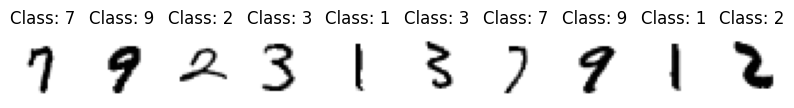

In [53]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

Let's define the network as a Python class. We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients. We select stochastic gradient descent (with momentum) as the optimization algorithm, and set learning rate to 0.01. Note that there are [several different options](https://pytorch.org/docs/stable/optim.html) for the optimizer in PyTorch that we could use instead of SGD.

In [54]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


## Learning

Let's now define functions to `train()` and `validate()` the model.



In [55]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [56]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

Now we are ready to train our model using the `train()` function. An epoch means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`.

In [57]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.290420
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.082144
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.346799
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.095045
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.971243
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.895630
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.671927
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.542963
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.507635
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.572818

Validation set: Average loss: 0.3749, Accuracy: 8964/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.431705
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.605885
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.779863
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.323678
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.570439
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.311744
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.600260
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.342054
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.52

Let's now visualize how the training progressed.

* Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time.
* Accuracy is the classification accuracy for the test data.

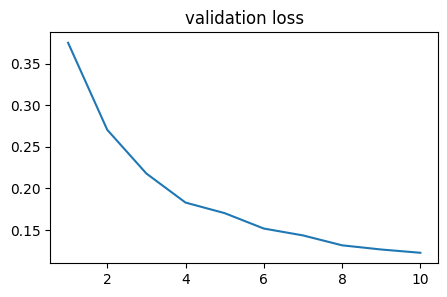

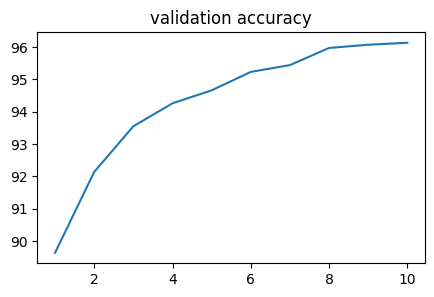

In [58]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');